In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
from PIL import Image, ImageDraw
import json
import sys
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 10]

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Unet architecture

In [2]:
def conv3d(in_channels, out_channels, stride=1, 
            padding=0, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2d(in_channels, out_channels, mode='transpose'):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=2,
        stride=2)


def conv1d(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super(Encoder, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3d(self.in_channels, self.out_channels)
        ## !TODO: adding batchnorm
        self.conv2 = conv3d(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x  # for skip connection
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

In [4]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 merge_mode='concat', up_mode='transpose'):
        super(Decoder, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2d(self.in_channels, self.out_channels, 
            mode=self.up_mode)

        self.conv1 = conv3d(2*self.out_channels, self.out_channels)

        self.conv2 = conv3d(self.out_channels, self.out_channels)


    def forward(self, from_down, from_up):
        from_up = self.upconv(from_up)

        x = torch.cat((from_up, from_down), 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [5]:
class UNet(nn.Module):

    def __init__(self, num_classes, in_channels=3, depth=5, 
                 start_filts=64, up_mode='transpose', 
                 merge_mode='concat'):

        super(UNet, self).__init__()

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = Encoder(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = Decoder(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1d(outs, self.num_classes)

        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, x):
        encoder_outs = []
         
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)
        
        x = self.conv_final(x)
        return x

## Helper functions

In [6]:
### ----- Image decoding ----
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def annotation(id, annotation_dir, shape):
# I think we don't really need this function since we can just
# use the decoded rle data to create the same image
    annotation_path = os.path.join(annotation_dir, id + ".json")
    with open(annotation_path) as f:
        annotation = np.array(json.load(f))
    ann_img = Image.new('L', (shape[0], shape[1]), 0)
    for poly in annotation:
        poly = [tuple(i) for i in poly]
        ImageDraw.Draw(ann_img).polygon(poly, outline=1, fill=1)
    return ann_img

### ----- Cleaning data -------
def remove_white_area(image):
    '''
      output is (2560, 2560, 3) for images and (2560, 2560) for labels
    '''
    size = 2560
    ### images
    if len(image.shape) == 3:
      if image.shape[0] >= size:
        x = (image.shape[0]-size)//2
        y = image.shape[1]-(image.shape[1]-size)//2

        if ((size-image.shape[0])%2 == 1):
          return image[x:y-1, x:y-1, :]
        return image[x:y, x:y, :]
      
      ## padding (add more white area)
      x = (size-image.shape[0])//2
      y = (size-image.shape[1])//2
      
      if ((size-image.shape[0])%2 == 1):
        return np.pad(image, ((x, x+1), (y, y+1), (0, 0)), constant_values=(245, 245))
      return np.pad(image, ((x, x), (y, y), (0, 0)), constant_values=(245, 245))
      
    ### labels
    if len(image.shape) == 2:
      if image.shape[0] >= size:
        x = (image.shape[0]-size)//2
        y = image.shape[1]-(image.shape[1]-size)//2

        if ((size-image.shape[0])%2 == 1):
          return image[x:y-1, x:y-1]
        return image[x:y, x:y]

      ## padding (add more white area)
      x = (size-image.shape[0])//2
      y = (size-image.shape[1])//2

      if ((size-image.shape[0])%2 == 1):
        return np.pad(image, ((x, x+1), (y, y+1)), constant_values=(0, 0))
      return np.pad(image, ((x, x), (y, y)), constant_values=(0, 0))

### ---- Create and reconstruc patches -------
# Batch patching functions for training
def batch_patches(batch, patch_size, dtype="images", collapse=False):
  # Assuming data in the form (N, 3, height, width) <-images  or (N, height, width) <-labels
  # If collapse is False: Returns tensor (N, img_dim[0] / patch_size, 3, patch_size, patch_size) (image) or same without "3" axis (label)
  # If collapse is True: Returns tensor (N * img_dim[0] / patch_size, 3, patch_size, patch_size) (image) or same without "3" axis (label)
  params = {"images":[2, 3], "labels":[1, 2]}
  params = params[dtype]
  patches = batch.unfold(params[0], patch_size, patch_size).unfold(params[1], patch_size, patch_size)
  if dtype=="images":
    patches = patches.contiguous().view(patches.size(0), patches.size(1), -1, patch_size, patch_size) 
    patches = patches.permute(0,2,1,3,4)
  else:
    patches = patches.contiguous().view(patches.size(0), -1, patch_size, patch_size) 
  if collapse:
    patches = patches.contiguous().view(-1, 3, patch_size, patch_size) if dtype=="images" else \
              patches.contiguous().view(-1, patch_size, patch_size)
  return patches

# Single image patching and reconstruction for prediction
def image_patch(img, patch_size):
  patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
  unfold_shape = patches.shape
  patches = patches.contiguous().view(patches.size(0), -1, patch_size, patch_size) 
  patches = patches.permute(1,0,2,3)
  return patches  

# TODO: finish image_recn function
def image_recon(patches):
  # patches is a tensor of shape (#ofpatches, patch_size, patch_size)
  # Assumes #ofpatches is a perfect square
  shape = patches.shape
  per_row = math.isqrt(shape[0])
  patch_size = shape[1]
  recon = patches.contiguous().view(per_row, per_row, patch_size, patch_size)
  recon = recon.permute(0,2,1,3).reshape(per_row*patch_size, per_row*patch_size)
  return recon

## Data set

In [7]:
class KaggleDataset(Dataset):
    #TODO maybe transform as separate function that takes images from KaggleDatabase 
    # and transforms and saves them to the img and label directories
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.labels = pd.read_csv(label_dir)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Labels
        labels = self.labels.iloc[index]
        id = str(labels['id'])
        # Image
        img_path = os.path.join(self.image_dir, id + ".tiff")
        image = np.array(Image.open(img_path).convert("RGB"))
        # rle
        rle = labels['rle']
        decoded_rle = rle_decode(rle, shape = image.shape[:2])

        # Transform
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=annotation)
            image = augmentations["image"]
            annotation = augmentations["annotation"]

        return torch.tensor(remove_white_area(image)), torch.tensor(remove_white_area(decoded_rle))

class PatchDS(Dataset):
    # Class used in training loop to load the patches in a batch 
    def __init__(self, images, labels):
        self.images= images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
      return self.images[index], self.labels[index]

In [8]:
IMAGES_DIRECTORY = "/kaggle/input/hubmap-organ-segmentation/train_images/"
ANNOTATION_DIRECTORY = "/kaggle/input/hubmap-organ-segmentation/train_annotations/"
TRAIN_LABEL_DIRECTORY = "/kaggle/input/hubmap-organ-segmentation/train.csv"

dataset = KaggleDataset(
    image_dir=IMAGES_DIRECTORY,
    label_dir=TRAIN_LABEL_DIRECTORY,
)

def cuda_mem(x='..'): # Function to check memory in gpu 
  print(f'{torch.cuda.memory_allocated() * 9.3e-10 :.2f} Gb used after: {x}')

In [9]:
# Training the Unet
device = "cuda" if torch.cuda.is_available() else "cpu"

learning_rate = 0.001
number_of_epoch = 4

model = UNet(num_classes=1, depth=3, merge_mode='concat').to(device)
#cuda_mem('model')
#criterion = nn.CrossEntropyLoss(weight=weight_tensor.to(device)).to(device) # With weights
criterion = nn.BCEWithLogitsLoss().to(device) # Without weights
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

img_batchsize = 3
patch_batchsize = 7
patch_size = 640

loss_plot = []
epoch_plot = []

loss_in_epoch = {i:[] for i in range(number_of_epoch)} # To save loss within epoch, every 30 images
for epoch in range(number_of_epoch):
    loss_epoch = []
    loader = DataLoader(dataset, batch_size=img_batchsize, shuffle=True)
    for i, (images, labels) in enumerate(loader):    
        img_patches = batch_patches(images.permute(0,3,1,2), patch_size, collapse=True).to('cpu')
        lab_patches = batch_patches(labels, patch_size, dtype="labels", collapse=True).to('cpu')
        patch_dataset = PatchDS(img_patches, lab_patches)
        patch_loader = DataLoader(patch_dataset, batch_size=patch_batchsize, shuffle=True)
        for j, (patches, labels) in enumerate(patch_loader):
            # Forward
            outputs = model(patches.float().to(device))[:,0,:,:]
            labels = labels.float().to(device)
            #cuda_mem('output, labels')
            loss = criterion(outputs, labels)
            #cuda_mem('loss')
            # Backwards
            optimizer.zero_grad()
            loss.backward()
            # gather data
            loss_epoch.append(loss.cpu().detach())
        if i % 10 == 0:
            if i == 0:
                avg_loss = loss.cpu().detach()            
            else:
                avg_loss = np.array(loss_epoch[-30:]).mean()
            loss_in_epoch[epoch].append(avg_loss)
            print(f'Epoch {epoch}: image: {(i+1) * 3} / {len(dataset)}, loss (last 30) = {avg_loss :.2f}')
    loss_epoch = np.array(loss_epoch)
    loss_plot.append(sum(loss_epoch) / len(loss_epoch))
    epoch_plot.append(epoch)

Epoch 0: image: 3 / 351, loss (last 30) = 7.14
Epoch 0: image: 33 / 351, loss (last 30) = 4.03
Epoch 0: image: 63 / 351, loss (last 30) = 3.42
Epoch 0: image: 93 / 351, loss (last 30) = 3.98
Epoch 0: image: 123 / 351, loss (last 30) = 4.48
Epoch 0: image: 153 / 351, loss (last 30) = 4.05
Epoch 0: image: 183 / 351, loss (last 30) = 4.81
Epoch 0: image: 213 / 351, loss (last 30) = 5.06
Epoch 0: image: 243 / 351, loss (last 30) = 3.56
Epoch 0: image: 273 / 351, loss (last 30) = 3.89
Epoch 0: image: 303 / 351, loss (last 30) = 2.84
Epoch 0: image: 333 / 351, loss (last 30) = 4.25
Epoch 1: image: 3 / 351, loss (last 30) = 6.06
Epoch 1: image: 33 / 351, loss (last 30) = 5.14
Epoch 1: image: 63 / 351, loss (last 30) = 4.21
Epoch 1: image: 93 / 351, loss (last 30) = 3.04
Epoch 1: image: 123 / 351, loss (last 30) = 4.83
Epoch 1: image: 153 / 351, loss (last 30) = 3.54
Epoch 1: image: 183 / 351, loss (last 30) = 4.32
Epoch 1: image: 213 / 351, loss (last 30) = 2.88
Epoch 1: image: 243 / 351, los

In [10]:
import pickle
torch.save(model, './model.pth')
np.savetxt("./loss_plot.csv", loss_plot, delimiter=",")
epoch_plot = np.array(epoch_plot)
np.savetxt("./epoch_plot.csv", epoch_plot, delimiter=",")
with open('./in_epoch_loss_dic.pkl', 'wb') as f:
    pickle.dump(loss_in_epoch, f)

In [11]:
# Save trained model
torch.save(model, 'model.pth')

## Testing

In [12]:
# Load trained model downloaded from kaggle and stored in results
# Notation: d=depth, e=epochs, i=images in batch, b=patchsize_#ofpatchesinbatch, w=weights(True of False)
model_path = ''
dic_path = model_path + 'in_epoch_loss_dic.pkl'

model = torch.load(model_path + 'model.pth', map_location=torch.device('cpu'))
with open(dic_path, 'rb') as f:
    loss_dic = pickle.load(f)
print(loss_dic)

{0: [tensor(7.1417), 4.0298853, 3.415624, 3.982807, 4.4849057, 4.0514503, 4.8078775, 5.063136, 3.5609076, 3.8910632, 2.8436213, 4.2543526], 1: [tensor(6.0635), 5.13778, 4.206581, 3.0425656, 4.832353, 3.5383058, 4.3167434, 2.884331, 3.4496574, 5.1775584, 3.9011662, 4.963088], 2: [tensor(0.5368), 2.995007, 4.8273783, 4.9451084, 4.52005, 5.2229676, 5.3408213, 4.111615, 4.742538, 5.561713, 4.800889, 3.7591813], 3: [tensor(0.0004), 4.732393, 2.9006407, 4.8314447, 3.078328, 4.8859115, 4.846754, 3.3148026, 2.8957245, 3.1997156, 5.274714, 4.741697]}


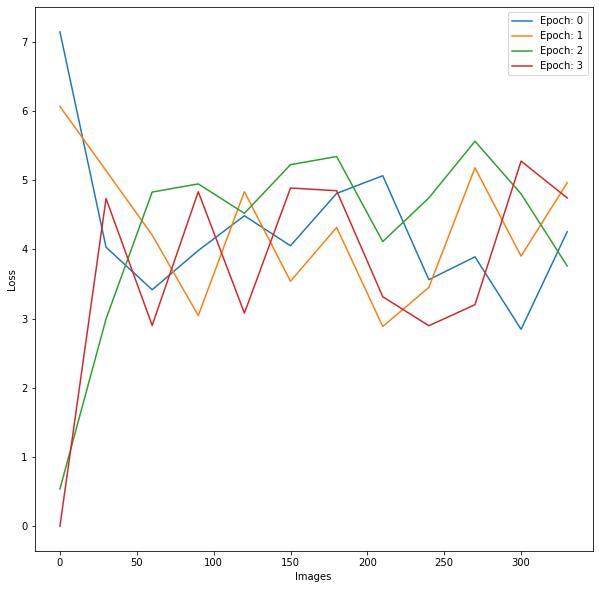

In [28]:
fig, ax = plt.subplots(1)
ax.set_ylabel('Loss')
ax.set_xlabel("Images")
for epoch, losses in loss_dic.items():
  x = [i * 30 for i in range(len(losses))]
  ax.plot(x, losses, label=f'Epoch: {epoch}')
ax.legend()
plt.savefig('640_7_3_binarryentropy_4epochs_351images_nomean.png')



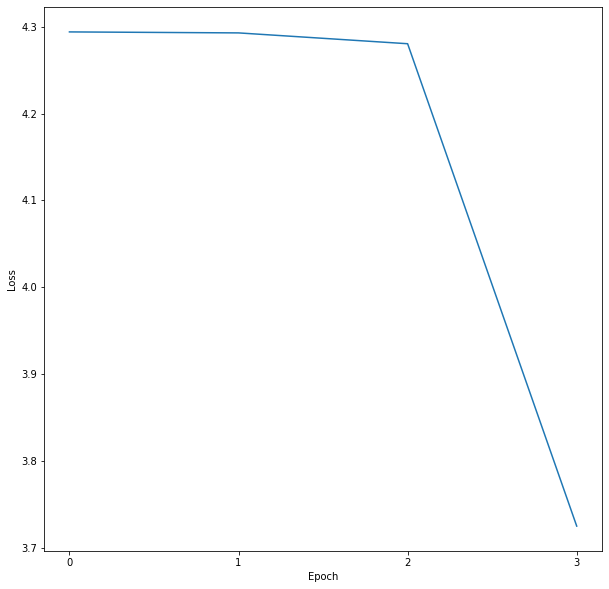

In [29]:
plot = []
for epoch, losses in loss_dic.items():
  if i == 9:
     break
  x = [i * 30 for i in range(len(losses))]
  plot.append(sum(losses)/len(losses))
    
plt.plot(plot)
plt.xticks(range(0,4))
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.savefig('640_7_3_binarryentropy_4epochs_351images.png')

AttributeError: module 'math' has no attribute 'isqrt'

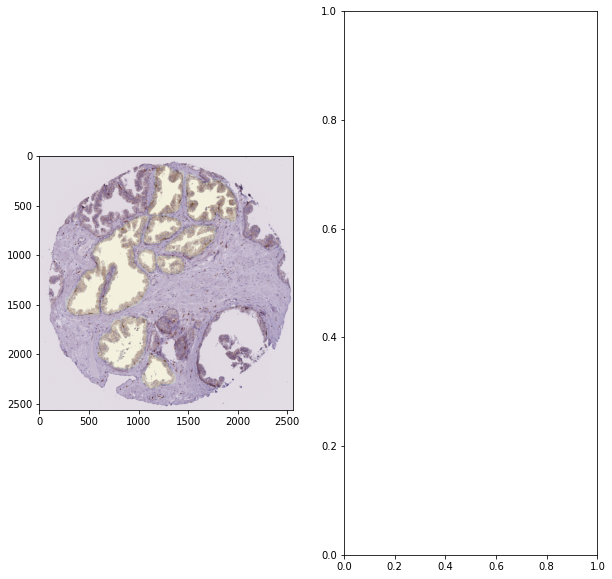

In [14]:
class metamodel():
  def __init__(self, model):
    self.model = model

  def predict(self, image, label):
    # label for plot of target
    # Plot objects
    fig, ax = plt.subplots(1,2)
    ax = ax.flatten()
    ax[0].imshow(img.permute(1,2,0))
    ax[0].imshow(label, alpha=0.1)

    patches = image_patch(image, 320*2)
    prediction = []
    for i, patch in enumerate(DataLoader(patches)):
      patch = patch.float()
      # pred = pred.type(torch.uint8)
      pred = model(patch).squeeze().softmax(0).argmax(0)
      pred = pred.detach()
      prediction.append(pred)
    prediction = torch.stack(prediction)
    prediction = image_recon(prediction)
    # ax[1].imshow(img.permute(1,2,0))
    ax[1].imshow(prediction) #, alpha=0.1)
    return prediction

meta = metamodel(model)
img, label = dataset[0]
img = img.permute(2, 0, 1)
pred = meta.predict(img, label)

In [ ]:
test = torch.where(pred>=0.5, 1, 0)
# # test = pred
fig, ax = plt.subplots(1)
# # ax.imshow(img.permute(1,2,0))
ax.imshow(test, alpha=0.2)

In [ ]:
# Testing patch function
# Images
image1 = dataset[5][0]
image1 = np.moveaxis(image1, [0, 1, 2], [1, 2, 0])
image1 = torch.from_numpy(image1)
image2 = dataset[6][0]
image2 = np.moveaxis(image2, [0, 1, 2], [1, 2, 0])
image2 = torch.from_numpy(image2)
img_batch = torch.stack([image1, image2])
og_imgshape = img_batch.shape
img_patches, img_ushape = batch_patches(img_batch, 320, dtype="images", recon=True)

# Labels
labels1 = dataset[5][1]
labels1 = torch.from_numpy(labels1)
labels2 = dataset[6][1]
labels2 = torch.from_numpy(labels2)
lab_batch = torch.stack([labels1, labels2])
og_labshape = lab_batch.shape
lab_patches, lab_ushape = batch_patches(lab_batch, 320, dtype="labels", recon=True)

# Plotting and reconstructing
# Img
pieces = 64
img_patches = img_patches.permute(0,1,3,4,2)
img_patches1 = img_patches[0]
lab_patches1 = lab_patches[0]
fig, ax = plt.subplots(math.isqrt(64), math.isqrt(64))
ax = ax.flatten()
for i in range(64):
    ax[i].imshow(img_patches1[i])
    ax[i].imshow(lab_patches1[i], alpha=0.1)
img_patches2 = img_patches[1]
lab_patches2 = lab_patches[1]
fig, ax = plt.subplots(math.isqrt(64), math.isqrt(64))
ax = ax.flatten()
for i in range(64):
    ax[i].imshow(img_patches2[i])
    ax[i].imshow(lab_patches2[i], alpha=0.1)